# **Import**

In [ ]:
#set up based on platform used
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB == True: #if using google colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !pip install tensorflow
    !unzip -q '/content/drive/MyDrive/data_equalize.zip' -d '/content/'
    !unzip -q '/content/drive/MyDrive/data_cropped_lungs.zip' -d '/content/'

    data_loc = "/content/data_equalize/Infection Segmentation Data" #working directory

    import os
    dir_imgs_train = os.path.join(data_loc,"Infection Segmentation Data/Train")
    dir_imgs_val = os.path.join(data_loc,"Infection Segmentation Data/Val")
    dir_imgs_test = os.path.join(data_loc,"Infection Segmentation Data/Test")

elif IN_COLAB == False: #if not using google colab (working locally with jupyter notebook)
    data_loc = "E:/covid-xray/" #working directory

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#location for MASKED data
data_loc = "/content/data_cropped_lungs/Infection Segmentation Data"

dir_imgs_train = os.path.join(data_loc,"Infection Segmentation Data/Train")
dir_imgs_val = os.path.join(data_loc,"Infection Segmentation Data/Val")
dir_imgs_test = os.path.join(data_loc,"Infection Segmentation Data/Test")

In [ ]:
#location for NOT MASKED data
data_loc = "/content/data_equalize/Infection Segmentation Data" #working directory

dir_imgs_train = os.path.join(data_loc,"Infection Segmentation Data/Train")
dir_imgs_val = os.path.join(data_loc,"Infection Segmentation Data/Val")
dir_imgs_test = os.path.join(data_loc,"Infection Segmentation Data/Test")

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import random

# **Image Generator**

In [ ]:
#IMAGE DATA GENERATOR
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
seed=42
dir_imgs_train = os.path.join(data_loc,"Train")
dir_imgs_val = os.path.join(data_loc,"Val")
dir_imgs_test = os.path.join(data_loc,"Test")
c_mode = "rgb" #rgb for transfer learning and grayscale for linear models
#preprocess_input = None    #used for simple models that were generated manually



train_data_generator = ImageDataGenerator(featurewise_center = True,
                                          rotation_range = 2,
                                          zoom_range = 0.05,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          horizontal_flip = True,
                                          fill_mode = "reflect",
                                          preprocessing_function = preprocess_input)

train_generator = train_data_generator.flow_from_directory(directory=dir_imgs_train, 
                                                           class_mode="sparse",
                                                           color_mode = c_mode,
                                                           target_size=(256,256), 
                                                           batch_size=32,
                                                           shuffle = True,
                                                           seed = seed)

val_generator = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory=dir_imgs_val, 
                                                           class_mode="sparse",
                                                         color_mode = c_mode,
                                                           target_size=(256,256), 
                                                           batch_size=32,
                                                           shuffle = True,
                                                           seed = seed)

test_generator = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory=dir_imgs_test, 
                                                           class_mode="sparse",
                                                          color_mode = c_mode,
                                                           target_size=(256,256), 
                                                           batch_size=32,
                                                           shuffle = False,
                                                           seed = seed)

Found 3728 images belonging to 3 classes.
Found 932 images belonging to 3 classes.
Found 1165 images belonging to 3 classes.


In [ ]:
#class names
train_generator.class_indices

{'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}

In [ ]:
np.unique(train_generator.classes, return_counts=True)

(array([0, 1, 2], dtype=int32), array([1864,  932,  932]))

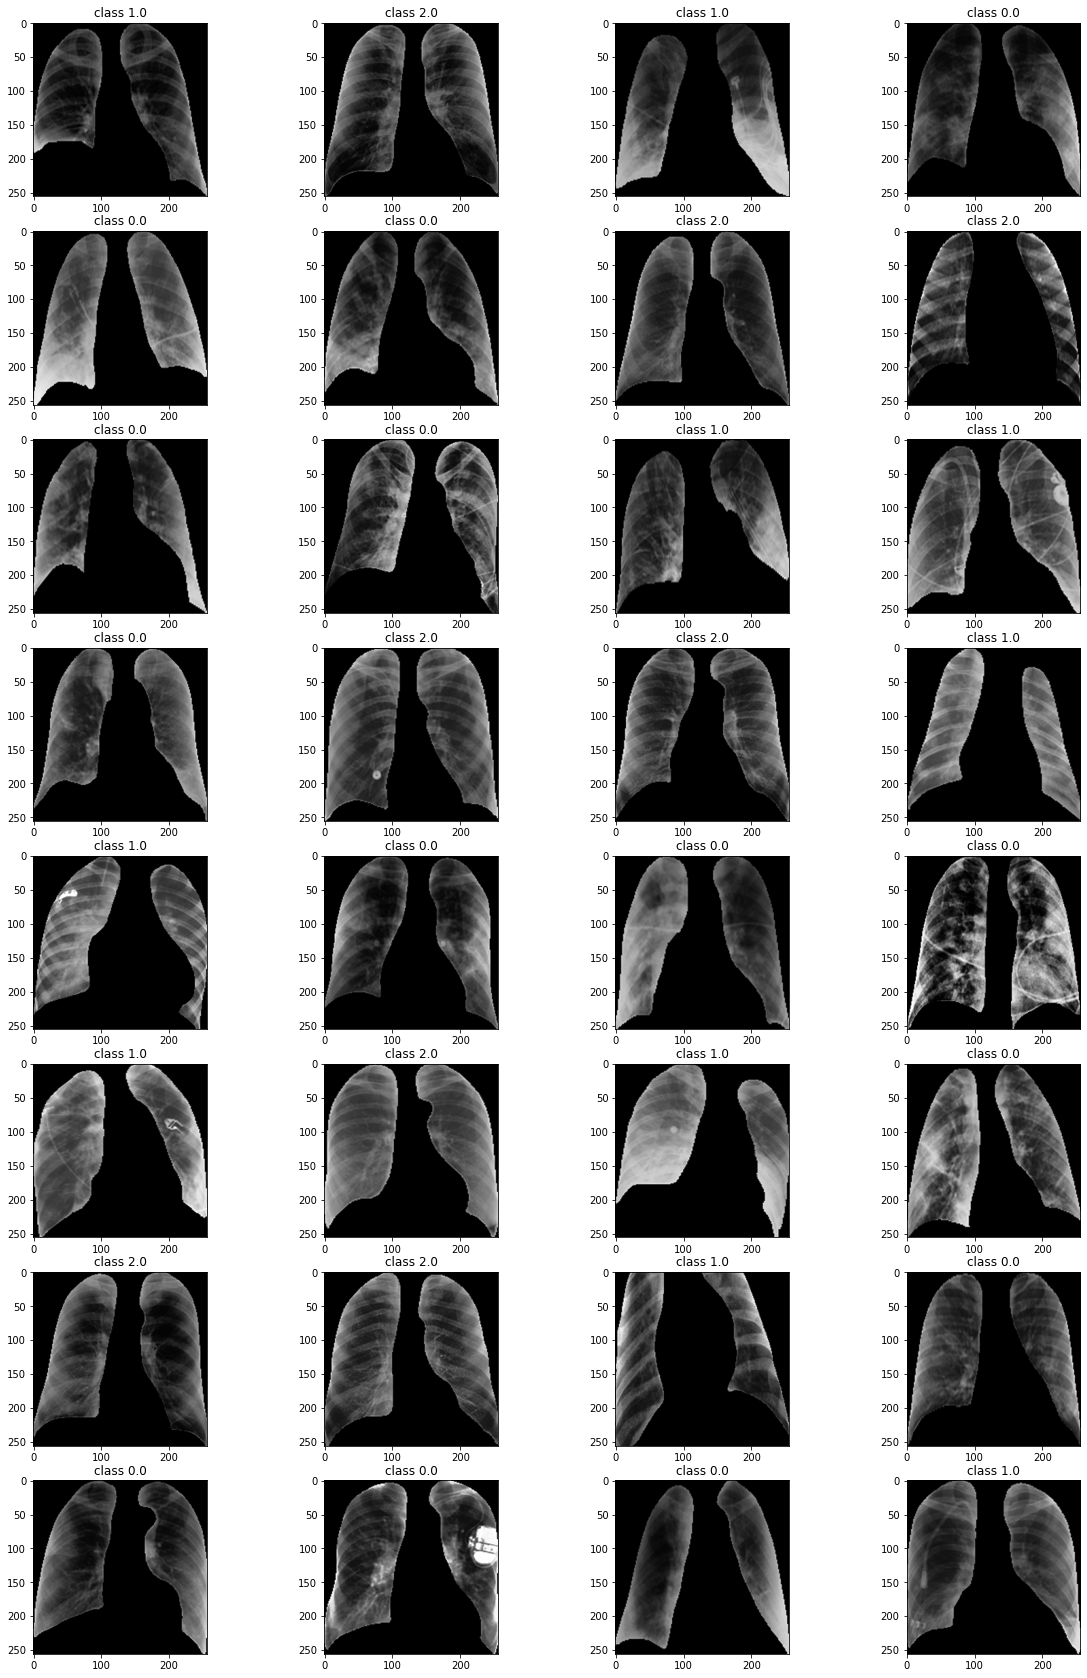

In [ ]:
#Image Data Generator testing/tuning
imgs_batch = train_generator.next()

fig, ax = plt.subplots(8,4, figsize=(20,30))
for i, img_tuple in enumerate(zip(imgs_batch[0],imgs_batch[1])):
  img, img_class = img_tuple
  img = img.reshape((256,256))
  ax.flatten()[i].imshow(img, cmap="gray")
  ax.flatten()[i].set_title("class " + str(img_class));

In [ ]:
#showing 
img_names_train

['COVID-19', 'Non-COVID', 'Normal']

In [ ]:
next(iter(enumerate(paths_train)))

(0,
 '/content/data_equalize/Infection Segmentation Data/Train/Non-COVID/images/non_COVID (321).png')

**In the following cells:** creating an array of images - for testing purposes

In [ ]:
dirs = []
count = []
lists = []

for x in os.walk(data_loc):
    if len(x[2]) > 4:  # looping only over the folders, which have more than 4 elements
        dirs.append(x[0])
        lists.append(x[2])
    count.append(len(x[2]))

df = pd.DataFrame({"path":dirs,
                    "folder-2":[item.split(sep="/")[-3] for item in dirs], #2 folders back in path
                    "folder-1":[item.split(sep="/")[-2] for item in dirs], #1 folder back in path
                    "folder":[item.split(sep="/")[-1] for item in dirs], #current folder
                    "img_name":lists}) #list of all element in current directory

df = df.explode("img_name").reset_index(drop=True)
df["path"] = df.apply(lambda row: os.path.join(row["path"], row["img_name"]), axis=1)

df.head()

,path,folder-2,folder-1,folder,img_name
0,/content/data_equalize/Infection Segmentation ...,Test,Non-COVID,images,non_COVID (3278).png
1,/content/data_equalize/Infection Segmentation ...,Test,Non-COVID,images,non_COVID (3264).png
2,/content/data_equalize/Infection Segmentation ...,Test,Non-COVID,images,non_COVID (3301).png
3,/content/data_equalize/Infection Segmentation ...,Test,Non-COVID,images,non_COVID (3263).png
4,/content/data_equalize/Infection Segmentation ...,Test,Non-COVID,images,non_COVID (11942).png


In [ ]:
paths_train = df[df['folder-2']=="Train"]["path"]
paths_val = df[df['folder-2']=="Val"]["path"]
paths_test = df[df['folder-2']=="Test"]["path"]

array_train = np.zeros([len(paths_train),256,256], dtype="uint8")
array_val = np.zeros([len(paths_val),256,256], dtype="uint8")
array_test = np.zeros([len(paths_test),256,256], dtype="uint8")



for i, path in enumerate(paths_train):
  array_train[i] = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

for i, path in enumerate(paths_val):
  array_val[i] = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

for i, path in enumerate(paths_test):
  array_test[i] = cv2.imread(path, cv2.IMREAD_GRAYSCALE)


print(array_train.shape, array_val.shape, array_test.shape)

array_train = array_train.reshape((-1,256,256,1))
array_val = array_val.reshape((-1,256,256,1))
array_test = array_test.reshape((-1,256,256,1))


(3728, 256, 256) (932, 256, 256) (1165, 256, 256)


In [ ]:
df[df['folder-2']=="Train"]["folder-1"].unique()

array(['Non-COVID', 'COVID-19', 'Normal'], dtype=object)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 42

train_data_generator = ImageDataGenerator()

train_generator = train_data_generator.flow(x = array_train, 
                                            y = df[df['folder-2']=="Train"]["folder-1"].replace(['Non-COVID', 'COVID-19', 'Normal'], [1, 2, 0]),
                                            batch_size=32,
                                            shuffle = True,
                                            seed = seed)

val_generator = ImageDataGenerator().flow(x = array_val, 
                                            y = df[df['folder-2']=="Val"]["folder-1"].replace(['Non-COVID', 'COVID-19', 'Normal'], [1, 2, 0]),
                                            batch_size=32,
                                            shuffle = True,
                                            seed = seed)

test_generator = ImageDataGenerator().flow(x = array_test, 
                                            y = df[df['folder-2']=="Test"]["folder-1"].replace(['Non-COVID', 'COVID-19', 'Normal'], [1, 2, 0]),
                                            batch_size=32,
                                            shuffle = True,
                                            seed = seed)

# **Linear**

## **Transfer Learning**

In [ ]:
#VGG16 bottom + custom top
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

input = keras.Input(shape=(256,256,3))

base_model = ResNet101(weights="imagenet", #tried imagenet weights, but achieved better results without
                   include_top=False,
                   input_tensor = input,
                   classes=3)
for layer in base_model.layers:
   layer.trainable = False    

x= GlobalAveragePooling2D()(base_model.output)
x = Dense(units=128, activation="relu")(x)
x = Dense(units=64, activation="relu")(x)
x = Dense(units=32, activation="relu")(x)
output = Dense(units=3, activation="softmax")(x)

model = keras.Model(inputs = input, outputs = output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

model.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_24[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
def scheduler(epoch, lr):
   if epoch < 3:
     return lr
   else:
     return 0.0005

schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
for layer in model.layers[:-4]:
   layer.trainable = True

In [ ]:
history = model.fit_generator(generator=train_generator,
                              validation_data = val_generator, 
                              #callbacks = [],
                              epochs = 10)

Epoch 1/10


<ipython-input-289-3b37b7db9d47>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


117/117 [==============================] - 40s 295ms/step - loss: 0.6316 - acc: 0.7320 - val_loss: 0.5355 - val_acc: 0.7618
Epoch 2/10
117/117 [==============================] - 33s 282ms/step - loss: 0.4395 - acc: 0.8222 - val_loss: 0.4491 - val_acc: 0.8283
Epoch 3/10
117/117 [==============================] - 33s 283ms/step - loss: 0.3923 - acc: 0.8417 - val_loss: 0.3966 - val_acc: 0.8294
Epoch 4/10
117/117 [==============================] - 33s 284ms/step - loss: 0.3488 - acc: 0.8600 - val_loss: 0.5589 - val_acc: 0.7897
Epoch 5/10
117/117 [==============================] - 33s 285ms/step - loss: 0.3428 - acc: 0.8621 - val_loss: 0.4153 - val_acc: 0.8369
Epoch 6/10
117/117 [==============================] - 33s 286ms/step - loss: 0.2885 - acc: 0.8860 - val_loss: 0.4010 - val_acc: 0.8466
Epoch 7/10
117/117 [==============================] - 34s 287ms/step - loss: 0.2886 - acc: 0.8871 - val_loss: 0.4619 - val_acc: 0.8273
Epoch 8/10
117/117 [==============================] - 33s 286ms/st

In [ ]:
from sklearn.metrics import classification_report

y_predict = np.argmax(model.predict_generator(test_generator),axis=1).reshape((1165))

y_true = test_generator.classes

print(pd.crosstab(y_predict,y_true, rownames=["prediction"], colnames=["true"]))
print(classification_report(y_predict, y_true))

In [ ]:
#saving performance history and description of model
model_name = "resnet101_1" 
dataset = "masked" 

#saving a summary and description of the model and model performance
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)

with open('/content/drive/MyDrive/hist/{}/{}.txt'.format(dataset, model_name), 'w') as f:
    f.write('{}: Second 10 epochs of training!\n\n'.format(model_name))
    f.write(classification_report(y_predict, y_true) + "\n\n")
    f.write(short_model_summary)

#saving model history as a dataframe in csv format
data = pd.DataFrame(history.history)
data.to_csv('/content/drive/MyDrive/hist/{}/{}_history.csv'.format(dataset, model_name))

In [ ]:
model.save("/content/drive/MyDrive/hist/models/{}/{}".format(dataset, model_name))

### **gradcam function definition**

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image, display
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### **gradcam function execution**

1/1 [==============================] - 2s 2s/step
Predicted: [[ 3.159289  -0.5452672 -2.0387313]]


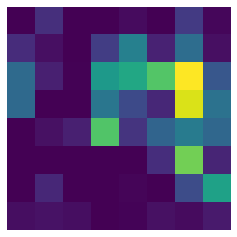

In [ ]:
img = cv2.imread("/content/data_cropped_lungs/Infection Segmentation Data/Test/COVID-19/lung masks/covid_1579.png")
img = img.reshape((1,256,256,3))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, "conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.axis("off")
plt.savefig("/content/drive/MyDrive/hist/{}/gradcam/{}_heat.png".format(dataset, model_name))
plt.show()

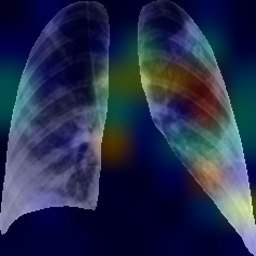

In [ ]:
save_and_display_gradcam(img.reshape(256,256,3), heatmap, 
                         cam_path = "/content/drive/MyDrive/hist/{}/gradcam/{}_gc.png".format(dataset, model_name))

1/1 [==============================] - 0s 25ms/step
Predicted: [[19.130304    5.220079   -0.02752471]]


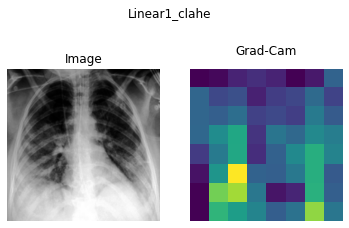

In [ ]:
img = cv2.imread("/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1579.png")
img = img.reshape((1,256,256,3))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
print("Predicted:", preds)

fig = plt.figure()
fig.suptitle("Linear1_clahe")
plt.subplot(121)
plt.imshow(img.reshape(256,256,3))
plt.axis("off")
plt.title("Image")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, "block5_pool")

# Display heatmap

ax2 = plt.subplot(122)
ax2.matshow(heatmap)
ax2.axis("off")
plt.title("Grad-Cam")

#plt.savefig("/content/drive/MyDrive/hist/{}/gradcam/{}.png".format(dataset, model_name))
plt.show()


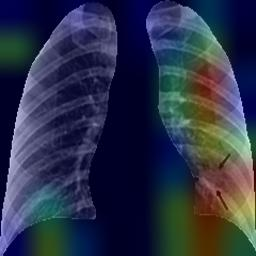

In [ ]:
from IPython.display import Image, display
import matplotlib.cm as cm
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img.reshape(256,256,3), heatmap)

In [ ]:
test_generator.filepaths

['/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1579.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1582.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1583.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1584.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1585.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1586.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1587.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1590.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1591.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1592.png',
 '/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1595.png',

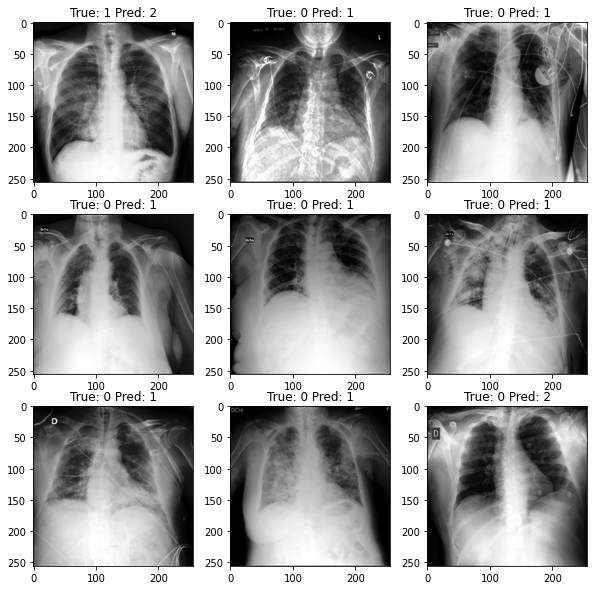

In [ ]:
paths = np.array([test_generator.filepaths, y_true, y_predict]).transpose()[y_true!=y_predict]

to_plot = random.choices(paths, k = 9)

fig, ax = plt.subplots(3, 3, figsize=(10,10))
for i, path_tuple in enumerate(to_plot):
  path, y_t, y_p = path_tuple
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  ax.flatten()[i].imshow(img, cmap="gray")
  ax.flatten()[i].set_title("True: "+y_t+" Pred: "+y_p) #0=covid, 1=non-covid, 2=normal
  ; 

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict_generator(test_generator)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(array_test, model, model.layers[0])

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: ignored

In [ ]:
model.layers

## **Simple linear models**

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Rescaling, RandomFlip, RandomRotation, RandomZoom, Input, Dropout, Dense

model1 = Sequential(name = "Linear1")

model1.add(Input((256,256,1)))

#convolutional neural networks - CNNs
model1.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", name="conv1"))
model1.add(MaxPooling2D(pool_size = (2, 2), name="maxpool1"))
model1.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu", name="conv2"))
model1.add(MaxPooling2D(pool_size = (2, 2), name="maxpool2"))
model1.add(Dropout(0.2, name="drop1"))
model1.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu", name="conv3"))
model1.add(MaxPooling2D(pool_size = (2, 2), name="maxpool3"))
model1.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu", name="conv4"))
model1.add(MaxPooling2D(pool_size = (2, 2), name="maxpool4"))
model1.add(Dropout(0.2, name="drop2"))
model1.add(Flatten(name="flatten"))

#fully connected layer
model1.add(Dense(128, activation = "relu", name="dense1"))
model1.add(Dense(64, activation = "relu", name="dense2"))
model1.add(Dense(32, activation = "relu", name="dense3"))
model1.add(Dense(3, activation = "softmax", name="dense4"))
model1.summary()

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

Model: "Linear1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 256, 256, 32)      320       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 128, 128, 32)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 128, 64)      18496     
                                                                 
 maxpool2 (MaxPooling2D)     (None, 64, 64, 64)        0         
                                                                 
 drop1 (Dropout)             (None, 64, 64, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 64, 64, 128)       73856     
                                                                 
 maxpool3 (MaxPooling2D)     (None, 32, 32, 128)       0   

In [ ]:
callbacks = []

history1 = model1.fit_generator(generator=train_generator,
                                validation_data = val_generator,
                                #callbacks = callbacks,
                                epochs=10)

Epoch 1/10


<ipython-input-168-329635425566>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(generator=train_generator,


117/117 [==============================] - 10s 89ms/step - loss: 0.1250 - acc: 0.9488 - val_loss: 0.7196 - val_acc: 0.7983
Epoch 2/10
117/117 [==============================] - 12s 102ms/step - loss: 0.1033 - acc: 0.9608 - val_loss: 0.5847 - val_acc: 0.8208
Epoch 3/10
117/117 [==============================] - 10s 86ms/step - loss: 0.1128 - acc: 0.9576 - val_loss: 0.7479 - val_acc: 0.8208
Epoch 4/10
117/117 [==============================] - 10s 86ms/step - loss: 0.1062 - acc: 0.9606 - val_loss: 0.6963 - val_acc: 0.8444
Epoch 5/10
117/117 [==============================] - 11s 89ms/step - loss: 0.0916 - acc: 0.9662 - val_loss: 0.8653 - val_acc: 0.7908
Epoch 6/10
117/117 [==============================] - 10s 86ms/step - loss: 0.0828 - acc: 0.9710 - val_loss: 0.8195 - val_acc: 0.8240
Epoch 7/10
117/117 [==============================] - 11s 94ms/step - loss: 0.0755 - acc: 0.9724 - val_loss: 0.6977 - val_acc: 0.8262
Epoch 8/10
117/117 [==============================] - 10s 85ms/step - lo

In [ ]:
from sklearn.metrics import classification_report

y_predict = np.argmax(model1.predict_generator(test_generator),axis=1).reshape((1165))

y_true = test_generator.classes

print(pd.crosstab(y_predict,y_true, rownames=["prediction"], colnames=["true"]))
print(classification_report(y_predict, y_true))

<ipython-input-169-cd99bb0a1a17>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_predict = np.argmax(model1.predict_generator(test_generator),axis=1).reshape((1165))


true          0    1    2
prediction               
0           557   24   11
1            12  225   58
2            13   43  222
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       592
           1       0.77      0.76      0.77       295
           2       0.76      0.80      0.78       278

    accuracy                           0.86      1165
   macro avg       0.83      0.83      0.83      1165
weighted avg       0.86      0.86      0.86      1165



In [ ]:
#saving performance history and description of model
model_name = "Linear1_2"
dataset = "not_masked"

#saving a summary and description of the model and model performance
stringlist = []
model1.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)

with open('/content/drive/MyDrive/hist/{}/{}.txt'.format(dataset ,model_name), 'w') as f:
    f.write('{}: training for {} 10 epochs!\n\n'.format(model_name, "first" if model_name[-1]=="1" else "second"))
    f.write(classification_report(y_predict, y_true) + "\n\n")
    f.write(short_model_summary)

#saving model history as a dataframe in csv format
data = pd.DataFrame(history1.history)
data.to_csv('/content/drive/MyDrive/hist/{}/{}_history.csv'.format(dataset, model_name))

In [ ]:
model1.save("/content/drive/MyDrive/hist/models/{}/{}".format(dataset, model_name))

### gradcam function definition

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

import matplotlib.cm as cm
from IPython.display import Image, display
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

### gradcam execution

1/1 [==============================] - 0s 15ms/step
Predicted: [[10.893003 -4.800366 -6.540142]]


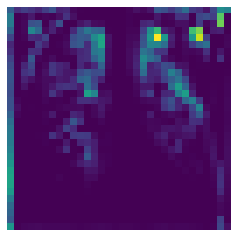

In [ ]:
img = cv2.imread("/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1579.png", cv2.IMREAD_GRAYSCALE)
img = img.reshape((1,256,256,1))

# Remove last layer's softmax
model1.layers[-1].activation = None

# Print what the top predicted class is
preds = model1.predict(img)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model1, "conv4")

# Display heatmap
plt.matshow(heatmap)
plt.axis("off")
plt.savefig("/content/drive/MyDrive/hist/{}/gradcam/{}_heat.png".format(dataset, model_name))
plt.show()

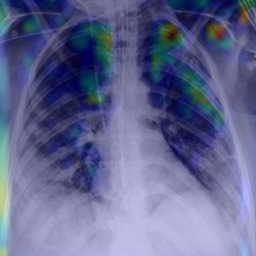

In [ ]:
save_and_display_gradcam(np.stack((img.reshape(256,256),)*3, axis=-1), heatmap, 
                         cam_path = "/content/drive/MyDrive/hist/{}/gradcam/{}_gc.png".format(dataset, model_name))

# **Visualisation of results**

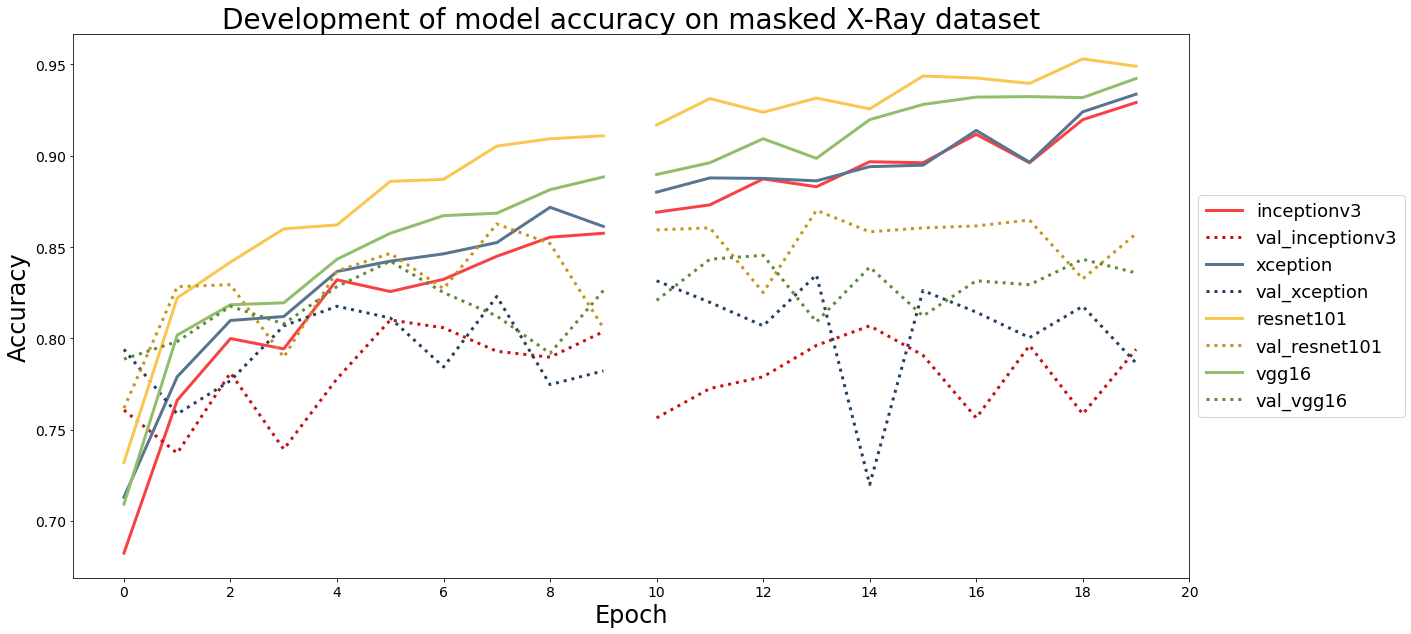

In [ ]:
dir = "/content/drive/MyDrive/hist/masked"
vars = []

#list_to_plot = ["Linear1_1_history.csv", "Linear1_2_history.csv",
#                "Linear2_1_history.csv", "Linear2_2_history.csv",
#                "Linear3_1_history.csv", "Linear3_2_history.csv"]

list_to_plot = ["vgg16_1_history.csv","vgg16_2_history.csv",
                "resnet101_1_history.csv","resnet101_2_history.csv",
                "xception_1_history.csv","xception_2_history.csv",
                "inceptionv3_1_history.csv", "inceptionv3_2_history.csv"]

#reading csv files in dir and adding variables to vars list
for file_ in os.listdir(dir):
  if file_ in list_to_plot:
    new_var = "_".join(file_.split("_")[:-1])
    exec(new_var + " = pd.read_csv(os.path.join(dir,file_), index_col=0)")
    if new_var[-2:] == "_2":
      exec(new_var + " = globals()[new_var].set_index(np.array(range(10,20)))")
    vars.append((new_var , globals()[new_var]))

#print(vars)


fig, ax = plt.subplots(1,1,figsize=(20,10))
ax
plt.title("Development of model accuracy on masked X-Ray dataset", fontsize=28)
colors = ["#f94144", "#577590", "#f9c74f","#90be6d","#277da1","#f3722c", "#f8961e", "#f9844a", "#43aa8b", "#4d908e"]
colors_val = ["#c61011", "#244260", "#c6941c","#608b3a","#166c90","#e2611b", "#e7850d", "#e87339", "#32997a", "#3c807d"]
c_name_list = []

for i, var in enumerate(vars):
  name, values = var
  if name.split("_")[0] not in c_name_list:
    c_name_list.append(name.split("_")[0])
  col_crit = c_name_list.index(name.split("_")[0])
  plt.plot(values.acc, label = name.split("_")[0], color=colors[col_crit], linewidth = 3)
  plt.plot(values.val_acc, label = "val_"+name.split("_")[0], color=colors_val[col_crit], linestyle = "dotted", linewidth = 3)

ax.tick_params(axis='both', labelsize=14)
plt.xlabel("Epoch", fontsize = 24)
plt.ylabel("Accuracy", fontsize = 24)
plt.xticks(range(0,21,2))

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 18)

#plt.tight_layout()


#plt.savefig("/content/drive/MyDrive/hist/masked/results/transfer_masked.png", bbox_inches = "tight");

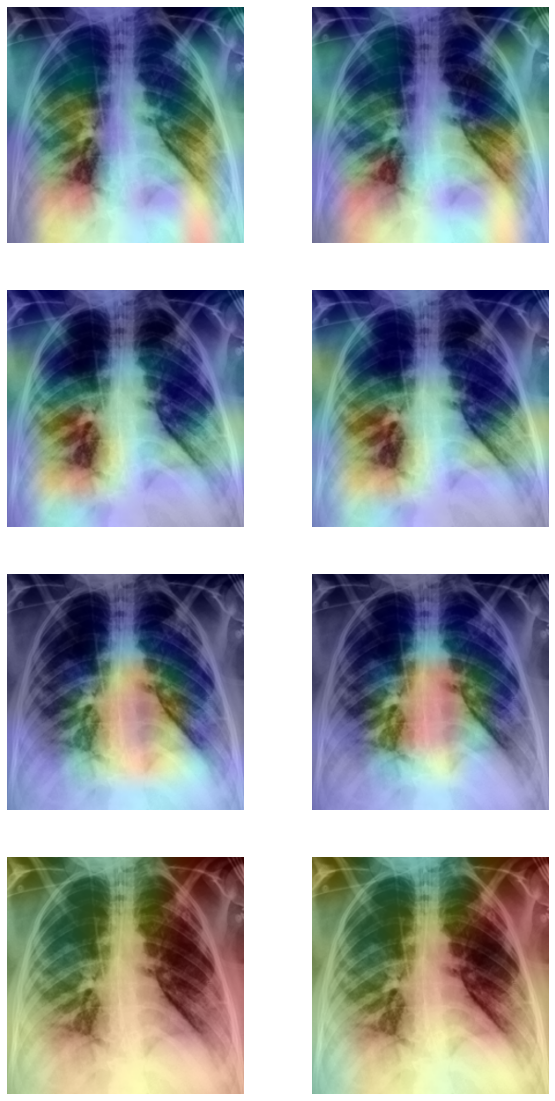

In [ ]:
fig, ax = plt.subplots(4,2, figsize =(10,20))

list_to_plot = ["vgg16_1_gc.png","vgg16_2_gc.png",
                "resnet101_1_gc.png","resnet101_2_gc.png",
                "xception_1_gc.png","xception_2_gc.png",
                "inceptionv3_1_gc.png", "inceptionv3_2_gc.png"]

#list_to_plot = ["Linear1_1_gc.png", "Linear1_2_gc.png",
#                "Linear2_1_gc.png", "Linear2_2_gc.png",
#                "Linear3_1_gc.png", "Linear3_2_gc.png"]

for i, img in enumerate(list_to_plot):
  imgp = cv2.imread("/content/drive/MyDrive/hist/not_masked/gradcam/{}".format(img), cv2.IMREAD_COLOR)
  imgp = cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB)
  ax.flatten()[i].imshow(imgp)
  ax.flatten()[i].axis("off")

#plt.savefig("/content/drive/MyDrive/hist/not_masked/results/gradcam_transfer.png")

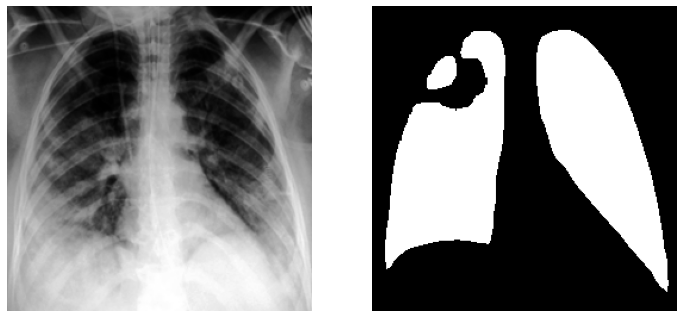

In [ ]:
fig, ax = plt.subplots(1,2, figsize =(12,6))

img = cv2.imread("/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1579.png")
ax.flatten()[0].imshow(img)
ax.flatten()[0].axis("off")

mask = cv2.imread("/content/covid_1579 (1).png")
ax.flatten()[1].imshow(mask)
ax.flatten()[1].axis("off")

plt.show()

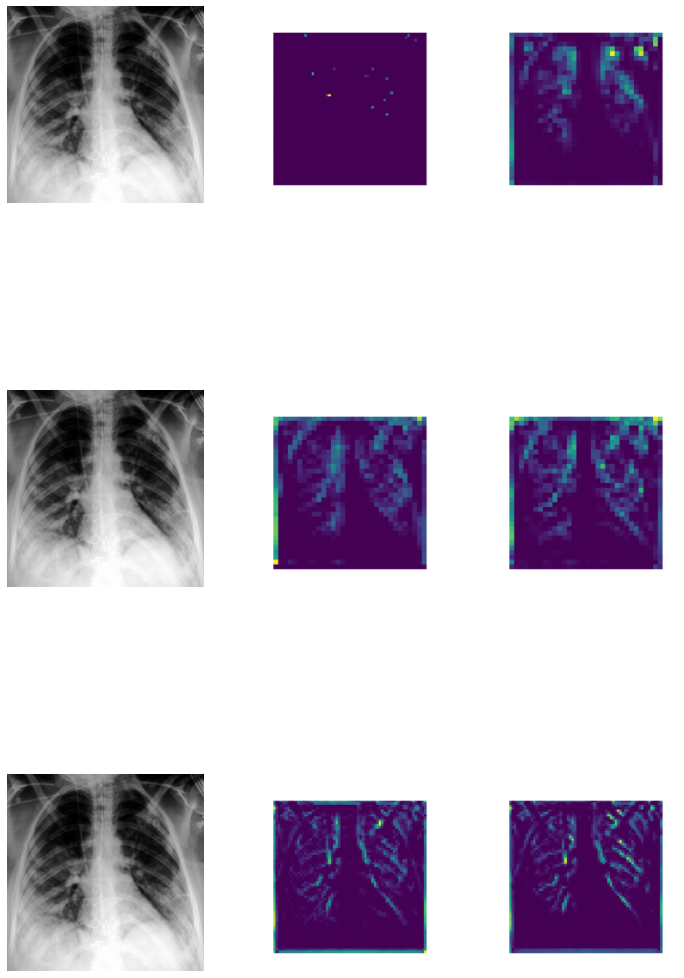

In [ ]:
fig, ax = plt.subplots(3,3, figsize =(12,20))

img0 = cv2.imread("/content/data_equalize/Infection Segmentation Data/Test/COVID-19/images/covid_1579.png")


#list_to_plot = [img0, "vgg16_1_heat.png","vgg16_2_heat.png",
#                img0,"resnet101_1_heat.png","resnet101_2_heat.png",
#                img0,"xception_1_heat.png","xception_2_heat.png",
#                img0,"inceptionv3_1_heat.png", "inceptionv3_2_heat.png"]

list_to_plot = [img0, "Linear1_1_heat.png", "Linear1_2_heat.png",
                img0, "Linear2_1_heat.png", "Linear2_2_heat.png",
                img0, "Linear3_1_heat.png", "Linear3_2_heat.png"]

for i, img in enumerate(list_to_plot):
  if i in [0,3,6,9]:
    ax.flatten()[i].imshow(img)
    ax.flatten()[i].axis("off")
  
  else:
    imgp = cv2.imread("/content/drive/MyDrive/hist/not_masked/gradcam/{}".format(img), cv2.IMREAD_COLOR)
    imgp = cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB)
    imgp = cv2.resize(imgp, (256,256))
    ax.flatten()[i].imshow(imgp)
    ax.flatten()[i].axis("off")

#plt.savefig("/content/drive/MyDrive/hist/not_masked/results/heatmap_linear.png")